In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
import torch
from copy import deepcopy

from shallow.torch import MAF, NSF

device = torch.device('cpu')
np.random.seed(42)

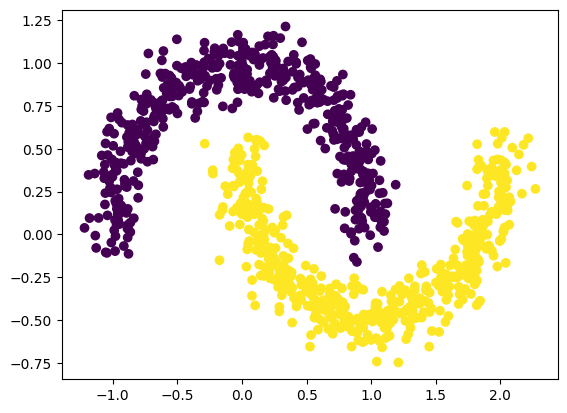

In [2]:
x, y = datasets.make_moons(1_000, noise=.1)
plt.scatter(*x.T, c=y);

In [81]:
def train(
    model,
    epochs=1000,
    batch_size=128,
    learning_rate=1e-3,
    weight_decay=0.,
    ):
    
    model = model.to(device)
    loss_fn = lambda inputs, conditions: -model.log_prob(inputs, conditions).mean()
    optimizer = torch.optim.Adam(
        model.parameters(), lr=learning_rate, weight_decay=weight_decay,
        )
    best_epoch = 0
    best_loss = np.inf
    best_model = deepcopy(model)
    
    for epoch in range(epochs):
        
        model.train()
        
        x, y = datasets.make_moons(batch_size, noise=.1)
        x = torch.tensor(x, dtype=torch.float32).to(device)
        y = torch.tensor(y[:, None], dtype=torch.float32).to(device)
        
        optimizer.zero_grad()
        loss = loss_fn(x, y)
        loss.backward()
        optimizer.step()
        
        loss = loss.item()
        if loss < best_loss:
            best_epoch = epoch
            best_loss = loss
            best_model = deepcopy(model)
            
        print(epoch, loss)
            
    return best_epoch, best_loss, best_model


def test_condition(
    model,
    condition=0.,
    n=200,
    lim=None,
    plot=True,
    ):
    
    model.eval()
    
    x = np.linspace(-lim, lim, n)
    y = np.linspace(-lim, lim, n)
    xg, yg = np.meshgrid(x, y)
    xg = np.reshape(xg, (-1, 1))
    yg = np.reshape(yg, (-1, 1))
    
    xy = np.concatenate([xg, yg], axis=1)
    
    with torch.no_grad():
        zg = model.log_prob(
            torch.tensor(xy, dtype=torch.float32),
            torch.tensor([[condition]]*n**2, dtype=torch.float32),
            ).exp().numpy().reshape(n, n)

    if plot:
        plt.imshow(
            zg, origin='lower', aspect='equal', extent=(-lim, lim, -lim, lim),
            )
        
    return zg
        
        
def test(model, n=200, lim=3):
    
    zg = np.zeros((n, n))
    for condition in [0, 1]:
        zg += test_condition(model, condition, n, lim, False)
        
    plt.imshow(
        zg, origin='lower', aspect='equal', extent=(-lim, lim, -lim, lim),
        )

## MAF

In [ ]:
maf = MAF(
    inputs=2,
    conditions=1,
    bounds=None,
    hidden=10,
    blocks=1,
    activation=torch.sigmoid,
    dropout=0.,
    norm_within=False,
    transforms=5,
    permutation='reverse',
    linear=None,
    norm_inputs=None,
    norm_conditions=None,
    norm_between=False,
    embedding=torch.nn.Identity(),
    distribution=None,
    residual=False,
    )

epoch, loss, maf = train(maf, learning_rate=1e-2)

0 6.011594772338867
1 5.626433849334717
2 5.269791126251221
3 4.9421868324279785
4 4.637957572937012
5 4.349285125732422
6 4.077496528625488
7 3.810149669647217
8 3.5463578701019287
9 3.299691915512085
10 3.0625
11 2.838850975036621
12 2.6508519649505615
13 2.4702322483062744
14 2.326974391937256
15 2.222841501235962
16 2.2001442909240723
17 2.1536808013916016
18 2.1198670864105225
19 2.0811944007873535
20 2.133739948272705
21 2.1590046882629395
22 2.1898603439331055
23 2.2039432525634766
24 2.1865928173065186
25 2.166072368621826
26 2.1769638061523438
27 2.1929357051849365
28 2.1419315338134766
29 2.0601589679718018
30 2.0501158237457275
31 2.0414745807647705
32 2.0013296604156494
33 2.0528159141540527
34 2.0296242237091064
35 1.9923633337020874
36 2.015899181365967
37 2.0232183933258057
38 2.0037994384765625
39 2.005601644515991
40 1.9988603591918945
41 2.0141913890838623
42 1.9960088729858398
43 2.0004498958587646
44 2.0063958168029785
45 1.9761885404586792
46 2.024679660797119
47 1

In [ ]:
test(maf, n=500, lim=2.5)

# NSF

In [ ]:
nsf = NSF(
    inputs=2,
    conditions=1,
    bounds=None,
    hidden=100,
    blocks=2,
    activation=torch.relu,
    transforms=3,
    permutation='reverse',
    norm_inputs=None,
    norm_conditions=None,
    norm_between=None,
    residual=False,
    )

epoch, loss, maf = train(nsf)